In [1]:
import sys, os
sys.path.append(os.pardir)

In [120]:
from pathlib import Path
import numpy as np
import polars as pl
import os
from hydra import initialize, compose
import plotly.express as px

with initialize(config_path="../run/conf", version_base=None):
    cfg = compose("cv_train")

In [11]:
def load_sakami_pred(cfg, name):
    pred_df = pl.concat(
            [ 
                pl.read_parquet(Path("/tmp/working/data/") / "009.parquet",columns=['series_id', 'step', 'timestamp']),
                pl.read_parquet(Path("/tmp/working/data/") / f'sakami/{name}/valid_preds.parquet')
            ], how="horizontal"
        ).with_columns(
            pl.col("step").cast(pl.UInt32)
        ).rename({
            "stacking_prediction_onset": f"{name}_stacking_prediction_onset",
            "stacking_prediction_wakeup": f"{name}_stacking_prediction_wakeup",
            })
    return pred_df.select(["series_id", "step", f"{name}_stacking_prediction_onset", f"{name}_stacking_prediction_wakeup"])


In [48]:
def load_shimacos_pred(cfg, name: str):
    pred_df = (
        pl.read_parquet(Path("/tmp/working/data/") / f"shimacos/{name}/result/pred_onset.parquet")
        .rename({"label_pred": f"{name}_stacking_prediction_onset"})
        .drop("label")
        .join(
            pl.read_parquet(Path("/tmp/working/data/")  / f"shimacos/{name}/result/pred_wakeup.parquet").rename(
                {"label_pred": f"{name}_stacking_prediction_wakeup"}).drop("label"),
            on=["series_id", "step"],
            how="left",
        ).with_columns(pl.col("step").cast(pl.UInt32))
    )
    return pred_df.select(["series_id", "step", f"{name}_stacking_prediction_onset", f"{name}_stacking_prediction_wakeup"])

In [58]:
train_df = pl.read_parquet(Path(cfg.dir.data_dir) / "train_series.parquet", columns=["series_id", "step", "timestamp"])
train_df = train_df.with_columns(pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")).filter(
    pl.col("step") % 12 == 0
)

In [108]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette("husl")



In [132]:
name = "004_transformer_category_padding_idx" # 009_cnn 011_cnn_embedding_sync
pred_df = load_sakami_pred(cfg, name)
pred_df = pred_df.join(train_df, on=['series_id', 'step'])

# fold番号をつける
pred_df = pred_df.with_columns(pl.lit(0).alias("fold"))
for fold in range(5):
    valid_ids = cfg[f"fold_{fold}"].valid_series_ids
    pred_df = pred_df.with_columns(
        pl.when(pl.col("series_id").is_in(valid_ids)).then(pl.lit(fold)).otherwise(pl.col("fold")).alias('fold')
    )

event="onset"

pred_df = pred_df.with_columns(
        pl.col("timestamp").dt.offset_by("2h").dt.date().alias("date")
).with_columns(
    pl.col(f"{name}_stacking_prediction_{event}").sum().over(["series_id", "date"]).alias("date_sum")
)


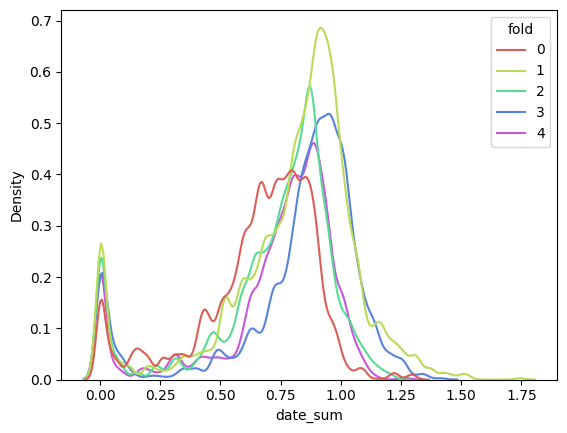

In [133]:
fig, ax = plt.subplots()
sns.kdeplot(pred_df, x="date_sum", hue="fold", palette=sns.color_palette("hls",5)
            , ax=ax)
plt.show()

In [123]:
name = 'stacking_exp059_030_truncate_lgbm'
pred_df = load_shimacos_pred(cfg, name)
pred_df = pred_df.join(train_df, on=['series_id', 'step'])


# fold番号をつける
pred_df = pred_df.with_columns(pl.lit(0).alias("fold"))
for fold in range(5):
    valid_ids = cfg[f"fold_{fold}"].valid_series_ids
    pred_df = pred_df.with_columns(
        pl.when(pl.col("series_id").is_in(valid_ids)).then(pl.lit(fold)).otherwise(pl.col("fold")).alias('fold')
    )

event="onset"

pred_df = pred_df.with_columns(
        pl.col("timestamp").dt.offset_by("2h").dt.date().alias("date")
).with_columns(
    pl.col(f"{name}_stacking_prediction_{event}").sum().over(["series_id", "date"]).alias("date_sum")
)


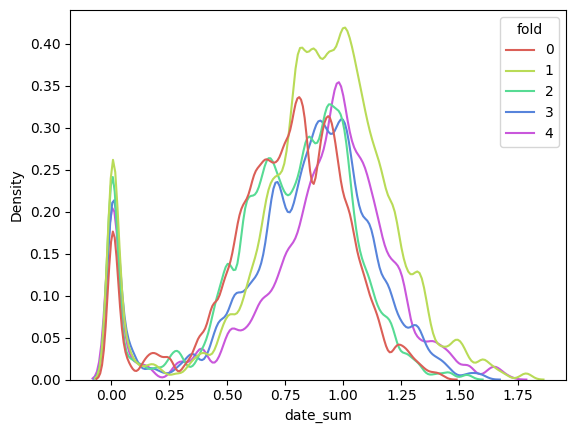

In [124]:
fig, ax = plt.subplots()
sns.kdeplot(pred_df, x="date_sum", hue="fold", palette=sns.color_palette("hls",5)
            , ax=ax)
plt.show()

In [125]:
#name = 'stacking_exp029_021_from_028_catboost' # gs://kaggle_cmi/shimacos/stacking_exp061_030_truncate_cat/result/pred_onset.parquet

name = 'stacking_exp061_030_truncate_cat'
pred_df = load_shimacos_pred(cfg, name)
pred_df = pred_df.join(train_df, on=['series_id', 'step'])


# fold番号をつける
pred_df = pred_df.with_columns(pl.lit(0).alias("fold"))
for fold in range(5):
    valid_ids = cfg[f"fold_{fold}"].valid_series_ids
    pred_df = pred_df.with_columns(
        pl.when(pl.col("series_id").is_in(valid_ids)).then(pl.lit(fold)).otherwise(pl.col("fold")).alias('fold')
    )

event="onset"

pred_df = pred_df.with_columns(
        pl.col("timestamp").dt.offset_by("2h").dt.date().alias("date")
).with_columns(
    pl.col(f"{name}_stacking_prediction_{event}").sum().over(["series_id", "date"]).alias("date_sum")
)


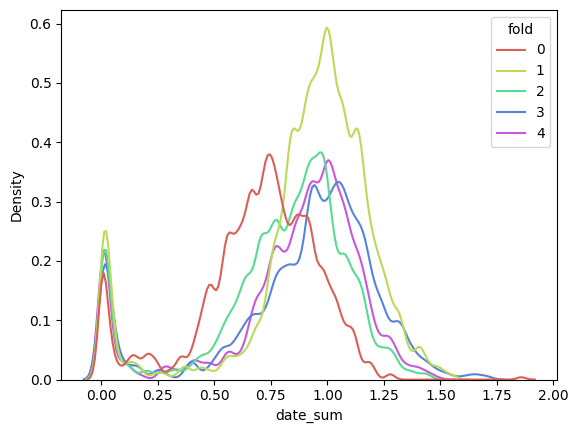

In [126]:
fig, ax = plt.subplots()
sns.kdeplot(pred_df, x="date_sum", hue="fold", palette=sns.color_palette("hls",5)
            , ax=ax)
plt.show()

In [128]:

def load_shimacos_nn_pred(cfg, name: str):
    pred_df = (
        pl.concat(
            [
                pl.read_parquet(Path("/tmp/working/data/")/ f"shimacos/{name}/fold{i}/result/valid.parquet") for i in range(5)
            ],
            how="vertical"
        )
    ).with_columns(
        pl.col("step").cast(pl.UInt32)
    ).with_columns(
            pl.col("step").cast(pl.UInt32)
    ).rename({
        "label_onset_pred": f"{name}_stacking_prediction_onset",
        "label_wakeup_pred": f"{name}_stacking_prediction_wakeup",}
    )
    return pred_df.select(["series_id", "step", f"{name}_stacking_prediction_onset", f"{name}_stacking_prediction_wakeup"])


In [130]:

name = 'stacking_exp060_030_truncate_small' 
pred_df = load_shimacos_nn_pred(cfg, name)
pred_df = pred_df.join(train_df, on=['series_id', 'step'])


# fold番号をつける
pred_df = pred_df.with_columns(pl.lit(0).alias("fold"))
for fold in range(5):
    valid_ids = cfg[f"fold_{fold}"].valid_series_ids
    pred_df = pred_df.with_columns(
        pl.when(pl.col("series_id").is_in(valid_ids)).then(pl.lit(fold)).otherwise(pl.col("fold")).alias('fold')
    )

event="onset"

pred_df = pred_df.with_columns(
        pl.col("timestamp").dt.offset_by("2h").dt.date().alias("date")
).with_columns(
    pl.col(f"{name}_stacking_prediction_{event}").sum().over(["series_id", "date"]).alias("date_sum")
)


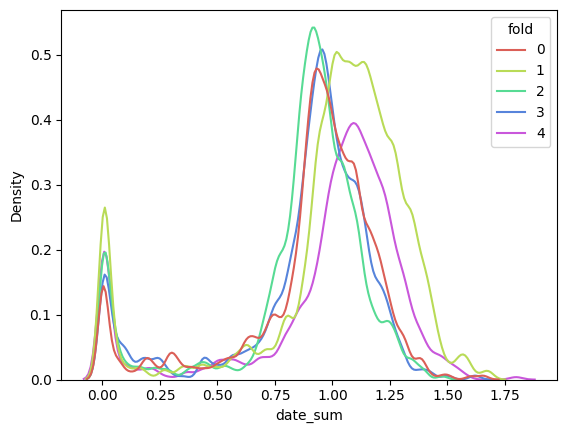

In [131]:
fig, ax = plt.subplots()
sns.kdeplot(pred_df, x="date_sum", hue="fold", palette=sns.color_palette("hls",5)
            , ax=ax)
plt.show()

KeyboardInterrupt: 

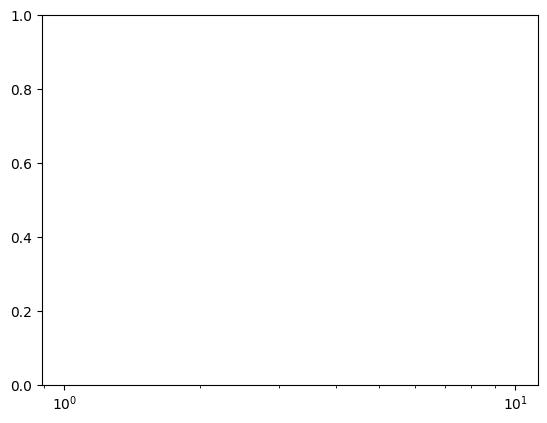

In [113]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
sns.kdeplot(pred_df, x=f"{name}_stacking_prediction_{event}", hue="fold", log_scale=True
            , ax=ax)
ax.set_xlim(1e-12, 1)
plt.show()



In [42]:
pred_df = load_sakami_pred(cfg, "009_cnn")

# fold番号をつける
pred_df = pred_df.with_columns(pl.lit(0).alias("fold"))
for fold in range(5):
    valid_ids = cfg[f"fold_{fold}"].valid_series_ids
    pred_df = pred_df.with_columns(
        pl.when(pl.col("series_id").is_in(valid_ids)).then(pl.lit(fold)).otherwise(pl.col("fold")).alias('fold')
    )
    
pred_df.to_pandas().groupby('fold')[['009_cnn_stacking_prediction_onset', '009_cnn_stacking_prediction_wakeup']].describe()

009_cnn_stacking_prediction_onset                                    \
                                 count      mean       std           min   
fold                                                                       
0                             368456.0  0.002672  0.027652  2.881873e-16   
1                             531142.0  0.002167  0.024226  3.922592e-15   
2                             374755.0  0.002572  0.029879  1.122415e-15   
3                             384917.0  0.002287  0.029567  2.075727e-17   
4                             324708.0  0.003063  0.030130  6.335275e-13   

                                                  \
               25%       50%       75%       max   
fold                                               
0     6.975533e-06  0.000059  0.000338  0.833373   
1     6.281637e-07  0.000012  0.000095  0.814326   
2     3.643969e-07  0.000003  0.000026  0.878737   
3     5.001449e-07  0.000010  0.000047  0.932673   
4     3.185055e-06  0.000028  0.000120  0.854549   

     009_cnn_stacking_prediction_wakeup                                    \
                                  count      mean       std           min   
fold                                                                        
0                              368456.0  0.003082  0.030892  7.592622e-13   
1                              531142.0  0.002070  0.024441  2.115476e-10   
2                              374755.0  0.002697  0.030356  2.337759e-13   
3                              384917.0  0.002320  0.030531  1.578836e-15   
4                              324708.0  0.003085  0.032605  9.378262e-10   

                                                  
               25%       50%       75%       max  
fold                                              
0     9.047211e-07  0.000006  0.000242  0.893574  
1     4.049388e-07  0.000001  0.000025  0.899021  
2     5.555421e-06  0.000015  0.000065  0.925922  
3     5.429782e-07  0.000002  0.000011  0.947365  
4     1.348447e-05  0.000036  0.000098  0.900629

In [49]:
name = 'stacking_exp028_021_from_016_192step'
pred_df = load_shimacos_pred(cfg, name)


# fold番号をつける
pred_df = pred_df.with_columns(pl.lit(0).alias("fold"))
for fold in range(5):
    valid_ids = cfg[f"fold_{fold}"].valid_series_ids
    pred_df = pred_df.with_columns(
        pl.when(pl.col("series_id").is_in(valid_ids)).then(pl.lit(fold)).otherwise(pl.col("fold")).alias('fold')
    ).with_columns(
            pl.col("timestamp").dt.offset_by("2h").dt.date().alias("date")
    ).with_columns(pl.col(event_pred_col).sum().over(["series_id", "date"]).alias("date_sum"))
    
pred_df.to_pandas().groupby('fold')[[f'{name}_stacking_prediction_onset', f'{name}_stacking_prediction_wakeup']].describe()

stacking_exp028_021_from_016_192step_stacking_prediction_onset            \
                                                              count      mean   
fold                                                                            
0                                              488147.0              0.001726   
1                                              659267.0              0.001450   
2                                              486743.0              0.001754   
3                                              512129.0              0.001989   
4                                              440073.0              0.002010   

                                                                  \
           std       min       25%       50%       75%       max   
fold                                                               
0     0.022326  0.000015  0.000015  0.000017  0.000038  0.890120   
1     0.018878  0.000004  0.000006  0.000009  0.000043  0.906657   
2     0.024822  0.000005  0.000006  0.000008  0.000036  0.896005   
3     0.027176  0.000003  0.000005  0.000011  0.000039  0.890211   
4     0.025129  0.000002  0.000004  0.000006  0.000031  0.880407   

     stacking_exp028_021_from_016_192step_stacking_prediction_wakeup  \
                                                               count   
fold                                                                   
0                                              488147.0                
1                                              659267.0                
2                                              486743.0                
3                                              512129.0                
4                                              440073.0                

                                                                            
          mean       std       min       25%       50%       75%       max  
fold                                                                        
0     0.001910  0.026351  0.000016  0.000016  0.000016  0.000049  0.892265  
1     0.001564  0.020316  0.000008  0.000009  0.000009  0.000061  0.857723  
2     0.001815  0.025111  0.000009  0.000010  0.000010  0.000060  0.850003  
3     0.001817  0.024703  0.000007  0.000007  0.000008  0.000040  0.837002  
4     0.002017  0.025588  0.000003  0.000004  0.000005  0.000043  0.871512

In [50]:
name = 'stacking_exp029_021_from_028_catboost'
pred_df = load_shimacos_pred(cfg, name)


# fold番号をつける
pred_df = pred_df.with_columns(pl.lit(0).alias("fold"))
for fold in range(5):
    valid_ids = cfg[f"fold_{fold}"].valid_series_ids
    pred_df = pred_df.with_columns(
        pl.when(pl.col("series_id").is_in(valid_ids)).then(pl.lit(fold)).otherwise(pl.col("fold")).alias('fold')
    )
    
pred_df.to_pandas().groupby('fold')[[f'{name}_stacking_prediction_onset', f'{name}_stacking_prediction_wakeup']].describe()

stacking_exp029_021_from_028_catboost_stacking_prediction_onset  \
                                                               count   
fold                                                                   
0                                              488147.0                
1                                              659267.0                
2                                              486743.0                
3                                              512129.0                
4                                              440073.0                

                                                                      \
          mean       std           min       25%       50%       75%   
fold                                                                   
0     0.001750  0.024235  1.211773e-07  0.000007  0.000060  0.000095   
1     0.001595  0.021949  4.188160e-07  0.000007  0.000022  0.000078   
2     0.001770  0.026184  1.925078e-08  0.000002  0.000009  0.000055   
3     0.001954  0.027350  7.518909e-08  0.000008  0.000031  0.000091   
4     0.001921  0.024994  7.206661e-08  0.000004  0.000019  0.000073   

                \
           max   
fold             
0     0.907991   
1     0.919182   
2     0.967359   
3     0.937194   
4     0.955791   

     stacking_exp029_021_from_028_catboost_stacking_prediction_wakeup  \
                                                                count   
fold                                                                    
0                                              488147.0                 
1                                              659267.0                 
2                                              486743.0                 
3                                              512129.0                 
4                                              440073.0                 

                                                                                
          mean       std           min       25%       50%       75%       max  
fold                                                                            
0     0.001986  0.029196  4.593991e-08  0.000005  0.000043  0.000098  0.967524  
1     0.001593  0.021422  1.015742e-07  0.000002  0.000058  0.000088  0.922775  
2     0.001840  0.027041  1.412535e-08  0.000001  0.000041  0.000087  0.963221  
3     0.001834  0.025173  8.363869e-08  0.000002  0.000029  0.000090  0.915449  
4     0.002003  0.025350  5.570513e-08  0.000004  0.000031  0.000074  0.900628

0 9225


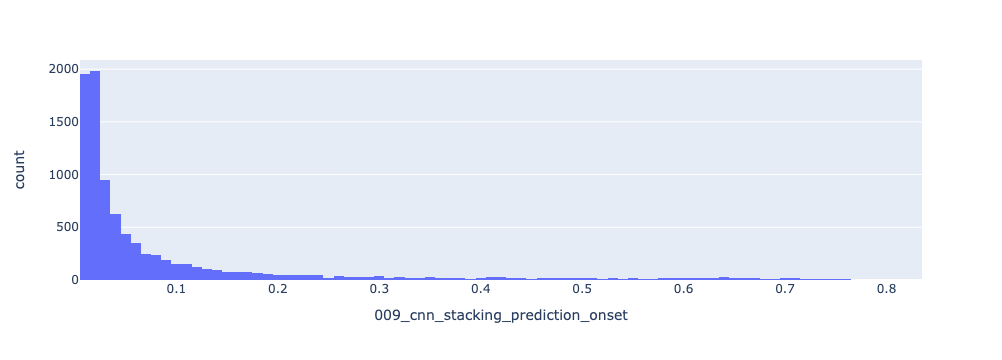

1 13751


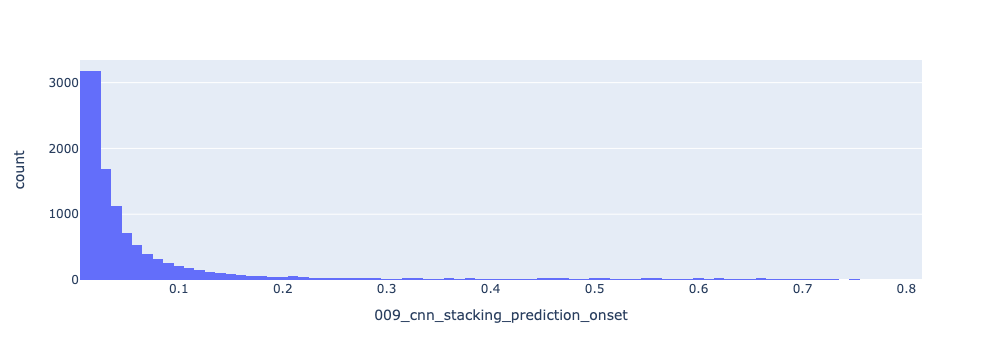

2 9116


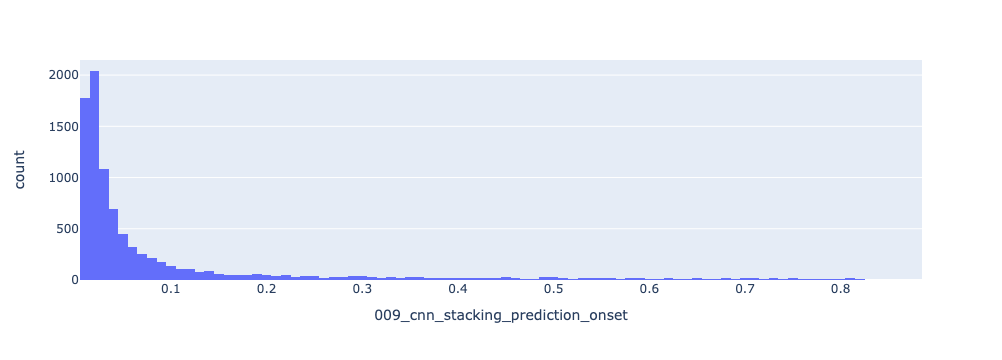

3 7432


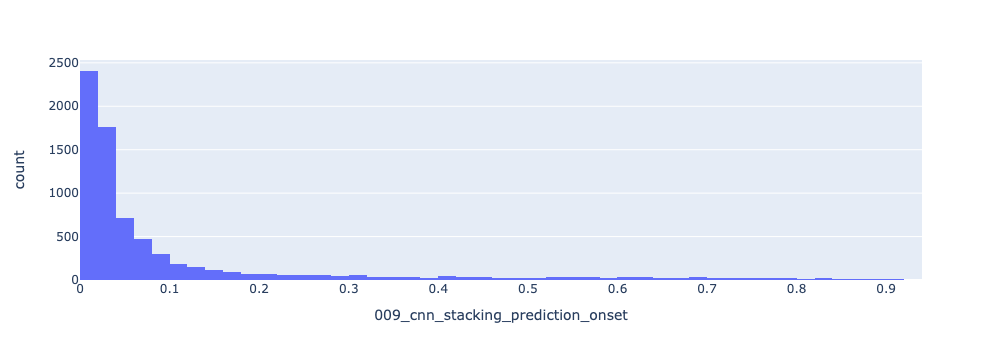

4 10760


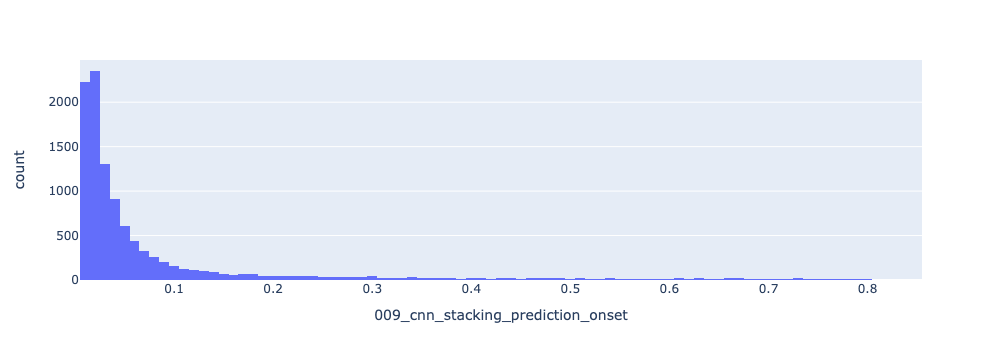

In [38]:
for fold in range(5):
    event = 'onset'
    name = "009_cnn"

    fold_df = pred_df.filter(pl.col('fold')==fold).filter(pl.col(f"{name}_stacking_prediction_{event}")>0.01)
    
    print(fold, len(fold_df))

    fold_df = fold_df.with_columns(
        pl.col(f"{name}_stacking_prediction_{event}")
    )

    fig = px.histogram(fold_df.to_pandas(), x=f"{name}_stacking_prediction_{event}")
    fig.show()
